### Task 1

This is Python source code for the character level RNN you studied in class. This is actually the very same code used to generate the examples shown in class (Shakespeare, C code etc). 

You will now analyze this model on your own, include output to ALL these points in your submission notebook, they all have marks. 

- Try different sequence lengths `(5,12,17,25)`
- Train the model and generate sequences for different kinds of files (atleast 3) (source code, novels, etc)
- Carefully look at the generated sequences from all models, and try to rationalize why the model gets stuck outputting the same characters if we choose a small sequence length.

- Plot training loss graphs for all combinations as a grid (`plt.subplots`), include these graphs in your submission notebook and include comments on which kinds of models train better or faster (use the loss as our considered variable)

QUESTION - Use the 'input.txt' file provided and set the sequence length to 3, what characters does it settle on as training goes on? Why does incresing the 

Answer - Some characters which it settles as the training goes on are small ones like Alas,sun,but and she.
With the increased sequence lenght the model started to learn bigger length words. Plus the loss is more noisy when sequence is small as compared to the larger one.


*You can get txt format books from Project Gutenberg*
*For the source code input try to find large codebases (think of how big the Linux one was)*
Code obtained from [here](https://gist.github.com/karpathy/d4dee566867f8291f086)

In [50]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""

'\nMinimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)\nBSD License\n'

In [76]:
import numpy as np

In [77]:
# data I/O
input_file = 'input.txt'

with open('input.txt', 'r') as f:
    data = f.read() # should be simple plain text file
    
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print ('data has {} characters, {} unique.'.format(data_size, vocab_size))

char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 208 characters, 33 unique.


In [78]:
print(char_to_ix)

{'x': 0, 'b': 1, ' ': 2, 'g': 3, 'd': 4, 's': 5, 'k': 6, 'S': 7, 'p': 8, 'r': 9, 'o': 10, 'T': 11, 'm': 12, 'f': 13, '.': 14, 'w': 15, 'n': 16, 'a': 17, 'q': 18, '!': 19, 'F': 20, ',': 21, 'u': 22, 'l': 23, 'h': 24, 'z': 25, 'A': 26, 'i': 27, 't': 28, 'j': 29, 'e': 30, 'c': 31, 'v': 32}


In [79]:
print (ix_to_char)

{0: 'x', 1: 'b', 2: ' ', 3: 'g', 4: 'd', 5: 's', 6: 'k', 7: 'S', 8: 'p', 9: 'r', 10: 'o', 11: 'T', 12: 'm', 13: 'f', 14: '.', 15: 'w', 16: 'n', 17: 'a', 18: 'q', 19: '!', 20: 'F', 21: ',', 22: 'u', 23: 'l', 24: 'h', 25: 'z', 26: 'A', 27: 'i', 28: 't', 29: 'j', 30: 'e', 31: 'c', 32: 'v'}


In [81]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 2 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [82]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [83]:
def lossFun(inputs, targets, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in range(len(targets)): 
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(targets))): 
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
        
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(targets)-1]

In [84]:
def sample(h, seed_ix, n):
    """ 
    sample a sequence of integers from the model 
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

In [85]:
n, p = 0, 0
loss_list=[]
iter_list=[]
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
while True:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print ('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % 100 == 0: 
        print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress
        print("loss is: ", loss)
        loss_list.append(loss)
        iter_list.append(n)
    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh,  Whh,  Why,  bh,  by ], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter

----
 x.,rFzpT wkhhFpzm jwubAvhTmlwntmbvw dd.ssbsozAelbdoS.fApubxcawja,jf!tcolgp.vmnwtp!grnvm,ckmrujkja.eSjlpglsxjTkhu,u!kfAaanl.xqalbnzTodvcwanwufmAdah!rjFimdSoAvfufapaeahvkwjjxwbepFgwkfqASthtzmnST gzAtAzs 
----
iter 0, loss: 6.993015
loss is:  6.99306860802667
----
  A  sr Au .atl . aAvasar kar ,teek e ps A ossASeheae. ts eoasea  o  ba fea  Se An ee S rs   ael .S a j  A!cid  hq  Aro  eawA  ie  aaA .e A Aw co a  A aqstsrfida eb  Anal ashA  eeaid   gx A amvA ng dle 
----
iter 100, loss: 7.270879
loss is:  8.720780572571398
----
 oaaiarbarcaaas aehssa satle rantlitAarnA toal aaraaaasaaalsaerssacaa.aitreaeasatacasrsssgah a atalslratslval oAssaqlsaaal sAcsnas a s aaaalaaasr aa  rsaaa r.ss .eagsvaasaerts e hroasa. sc assasa sa,Aa 
----
iter 200, loss: 7.306174
loss is:  10.017841050311077
----
 teersheruhearrrweew uereerao wteehseatratwrsertstbAtdoiccaeer eeeeaheat ieetleeeeesreresertrenrmewmt thrar rtenue ate enrert aiwterctt Seo.er ertwtaoer a ee eotartewdeererisec rrenteetenaaoheersne ,

KeyboardInterrupt: 

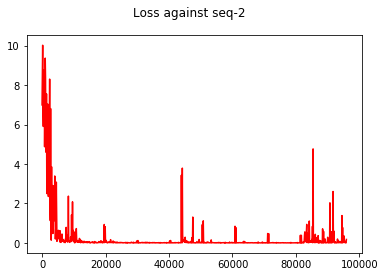

In [86]:
import matplotlib.pyplot as plt 
plt.plot(iter_list,loss_list, c='r')
plt.suptitle('Loss against seq-2')
plt.show()